## Preparation

First, let's download some data

In [ ]:
! wget https://github.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/raw/master/data/ptb.train.txt
! wget https://github.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/raw/master/data/ptb.valid.txt

# KenLM doesn't support <unk>, so let's remove it
! sed -e 's/<unk>//g' ptb.train.txt > ptb.train.nounk.txt

--2021-09-25 21:40:59--  https://github.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/raw/master/data/ptb.train.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/master/data/ptb.train.txt [following]
--2021-09-25 21:40:59--  https://raw.githubusercontent.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/master/data/ptb.train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5101618 (4.9M) [text/plain]
Saving to: ‘ptb.train.txt’

ptb.train.txt       100%[===================>]   4.87M  --.-KB/s    in 0.08s   

2021-09-25 21:41:00 (59.4 MB

In [ ]:
! head -n 5 ptb.train.nounk.txt

 aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre  N years old will join the board as a nonexecutive director nov. N 
 mr.  is chairman of  n.v. the dutch publishing group 
 rudolph  N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate 
 a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported 


## Building an N-gram language model with Tries

In this lab, we are going to explore N-gram language models.

The idea behind N-gram language models is that we want to learn a distribution over text sequences, looking only at windows of N tokens at a time. At its core, we are concerned with learning the following distribution:

$$P(x_t|x_{t-1}, \cdots, x_{t-n+1})$$

In other words, the **conditional distribution** of the next token given the last $n-1$ tokens. We can use this conditional distribution for language modeling as follows:

\begin{align}
P(x_1 \cdots x_T) 
  &= P(x_1)P(x_2|x_1)\cdots P(x_T|x_{t-1}, \cdots, x_1) \\
  &\approx P(x_1)P(x_2|x_1)\cdots P(x_T|x_{t-1}, \cdots, x_{t-n+1})
\end{align}

where in the second step, we make the assumption that only the last $n-1$ tokens are relevant for predicting the next token. This is how we can use N-gram models for language modeling.

(We will temporarily ignore edge cases such as "what do you do when you have fewer than N tokens". Those cases require some more tedious handling, such as adding padding tokens.)

The simplest approach to this is a **count-based** approach, where we take a large corpus of text (our "training corpus"), break it up into segments of size N, and count how often we see each N-gram.

### Trie-based N-gram Language Modeling

**Tries** or **Prefix Trees** are a data structure that allow for fast look-ups based on prefixes. This is particularly useful for build N-gram models, what we want is to know the distribution of the next token given a prefix of N-1 tokens.

(For a simple N-gram model, you could also just use a big dictionary, but we will see below with *back-off* why a prefix tree is more useful.)

(*Trie* is based on the word re**trie**val, and can be pronounced either like "tree" or "try".)

It is easiest to see how a trie works by an example. Suppose we have a simple text corpus that just consists of the following 3-grams:

```
new york university
new york university
new york city
new jersey transit
one two three
```

This can be expressed with the following trie:

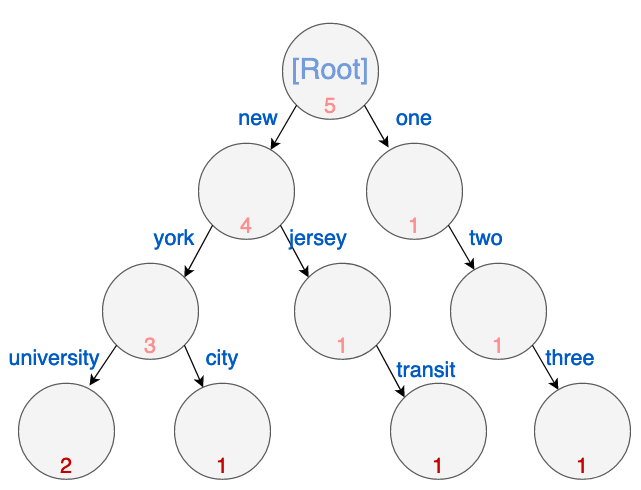

As we can see, we start with a root node, and break down each successful token into a new branch in the tree. We are most concerned with the counts in the leaf nodes of the tree.

For an N-gram language model, we only need our trie to go up to depth N.

Here is some simple code to implement a trie for N-grams.

In [ ]:
import numpy as np

class Node:
    def __init__(self):
        self.count = 0
        self.child_nodes = {}

    def has_token(self, token):
        return token in self.child_nodes

    def create_child_node(self, token):
        self.child_nodes[token] = Node()

    def increment_count(self):
        self.count += 1
    
    def get_child_node(self, token):
        if token not in self.child_nodes:
            raise KeyError(f"'{token}' not found in child node")
        return self.child_nodes[token]
        

class NgramTrie:
    def __init__(self, n):
        self.n = n
        self.root_node = Node()
        self.vocab = set()
    
    def add_ngram(self, ngram):
        if len(ngram) > self.n:
            raise RuntimeError(f"This NgramTrie only supports up to {n}-grams")

        # Update vocabulary
        self.vocab.update(ngram)

        # Update Trie
        current_node = self.root_node
        current_node.increment_count()
        for token in ngram:
            if not current_node.has_token(token):
                current_node.create_child_node(token)
            current_node = current_node.get_child_node(token)
            current_node.increment_count()

We can express the above tree as follows.

In [ ]:
sample_trie = NgramTrie(n=3)
sample_trie.add_ngram(["new", "york", "university"])
sample_trie.add_ngram(["new", "york", "university"])
sample_trie.add_ngram(["new", "york", "city"])
sample_trie.add_ngram(["new", "jersey", "transit"])
sample_trie.add_ngram(["one", "two", "three"])
print("new york university", sample_trie.root_node.get_child_node("new").get_child_node("york").get_child_node("university").count)
print("one two three", sample_trie.root_node.get_child_node("one").get_child_node("two").get_child_node("three").count)
print("new", sample_trie.root_node.get_child_node("new").count)

Now, let's train a 4-gram model on our PTB corpus

In [ ]:
# Get all lines from training corpus
def load_lines(path):
    with open(path, "r") as f:
        lines = []
        for line in f:
            line = line.strip()
            if not line: 
                continue
            lines.append(line)
    return lines
lines = load_lines("ptb.train.nounk.txt")

# Add all data into 4-gram Trie
n = 4
trie_4gram = NgramTrie(n=4)
for line in lines:
    sequence = ["<bos>"] + line.split() + ["<eos>"]
    # for each ngram (sliding window)
    for i in range(len(sequence)-n+1):
        ngram = tuple(sequence[i:i+n])
        trie_4gram.add_ngram(ngram)

Now that we have a trie for storing our 4-gram counts, we can easily compute the conditional distribution. We simply need to look up to 3-nodes down the trie, and compute the distribution based on the counts of tokens with that 3-gram prefix.

In [ ]:
def get_ngram_cond_dist(trie, input_ngram):
    """Get simple n-gram conditional distribution from trie.

    Arguments:
      trie: NgramTrie
      input_ngram: Tuple of n-1 tokens

    Returns:
      Dictionary mapping each possible token->conditional probability
    """
    current_node = trie.root_node
    for token in input_ngram:
        current_node = current_node.get_child_node(token)
    # Get count for each child node
    child_counts = {}
    for token, node in current_node.child_nodes.items():
        child_counts[token] = node.count

    # Divide by total counts
    total_count = sum(child_counts.values())
    child_prob = {}
    for token, count in child_counts.items():
        child_prob[token] = count / total_count
    return child_prob

For instance, we can compute the conditional distribution of tokens with a sentence starting with "the new":

In [ ]:
seed_tokens = ["<bos>", "new", "york"]
dist = get_ngram_cond_dist(trie_4gram, seed_tokens)
dist

Now that we know how to construct a conditional distribution based on N-grams, we can repeatedly sample from that distribution, append it to our input, and generate text that way!

We set two terminal conditions to stop generating more tokens.

1. If we encounter an `<eos>` token
2. If we have generated `max_length` tokens (this stops us from being trapped in a loop)

You should see that the generated text may not make sense overall (globally), but looks reasonable in small (local) windows.

In [ ]:
def sample_from_distribution(dist):
    tokens, p = zip(*dist.items())
    return np.random.choice(tokens, p=p)

def sample_from_trie(trie, seed_tokens, cond_dist_func, max_length=20):
    all_tokens = seed_tokens.copy()
    for i in range(max_length):
        input_tokens = all_tokens[-(trie.n-1):]
        dist = cond_dist_func(trie_4gram, input_tokens)
        new_token = sample_from_distribution(dist)
        all_tokens.append(new_token)
        if new_token == "<eos>":
            break
    return all_tokens

seed_tokens = ["<bos>", "the", "new"]
generated_tokens = sample_from_trie(
    trie=trie_4gram, 
    seed_tokens=seed_tokens,
    cond_dist_func=get_ngram_cond_dist
)
print("Generated: " + " ".join(generated_tokens))

## Expanding our N-gram model

Our count-based N-gram model suffers from the fact that it strictly adheres to the N-grams it has seen before. This can be quite restrictive, particularly if we have small training corpus. We can make two adjustments to our model.

### Back-off

One approach to dealing with unseen N-grams is "back-off". Consider the following case: the model has never seen a sentence *starting with* "new mexico".

In [ ]:
# FAILS: No sentence starting with "New Mexico" in the training corpus
get_ngram_cond_dist(trie_4gram,  ["<bos>", "new", "mexico"])

However, the term "new mexico" does appear in the training corpus - just not at the start of a sentence. In this case, when we fail to find a matching 4-gram, we can consider falling back to a 3-gram model.

Here, a trie proves useful, because it is easy for us to fall back to smaller N N-grams.

Hence, we can write a modified conditional distribution function that *backs off* to smaller and smaller N-grams. In the extreme, if the model is given an input with tokens it has never seen before, it will fall back to the root node and sample from a unigram model, i.e. the unconditional distribution of tokens.

In [ ]:
def get_ngram_cond_dist_backoff(trie, input_ngram):
    # Repeatedly back-off to smaller N
    while True:
        current_node = trie.root_node
        matched = True
        for token in input_ngram:
            # Did not find token: reduce n-gram
            if not current_node.has_token(token):
                input_ngram = input_ngram[1:]
                matched = False
                break
            current_node = current_node.get_child_node(token)

        # Successfully matched n-gram, break out of loop
        if matched:
          break

    if len(input_ngram) != trie.n:
        print(f"Fell back to {len(input_ngram)+1}-gram")
        
    # Get count for each child node
    child_counts = {}
    for token, node in current_node.child_nodes.items():
        child_counts[token] = node.count

    # Divide by total counts
    total_count = sum(child_counts.values())
    child_prob = {}
    for token, count in child_counts.items():
        child_prob[token] = count / total_count
    return child_prob


In [ ]:
# Succeeds: falls back to 3-gram
get_ngram_cond_dist_backoff(trie_4gram,  ["<bos>", "new", "mexico"])

In [ ]:
# No such thing as "New Canada": Falls back to 2-gram
get_ngram_cond_dist_backoff(trie_4gram,  ["<bos>", "new", "canada"])

In [ ]:
# OOV: Falls back to 1-gram (sample from root-node)
get_ngram_cond_dist_backoff(trie_4gram,  ["<bos>", "new", "sdfklhkashdfkjasf"])

### Add-1 smoothing

Alternatively we may be interested in increasing the expressivity to our model, by assigning some probability mass to conditional distribution of the next token, even for N-grams that the model has never seen before. One simple approach to this is "add-1 smoothing", where we simply add 1 to the counts of each tokens for all tokens in the vocab, and then compute the conditional distribution. This is akin to imposing a prior that "every possible N-gram appears at least once".

Importantly, all unseen N-grams will be assigned the same probability.

In [ ]:
def get_ngram_cond_dist_add1_smoothing(trie, input_ngram):
    current_node = trie.root_node
    try:
        # Traverse trie
        for token in input_ngram:
            current_node = current_node.get_child_node(token)
        # Get count for each child node
        child_counts = {}
        for token, node in current_node.child_nodes.items():
            child_counts[token] = node.count
    except KeyError:
        # Unseen N-gram
        child_counts = {}

    # ADD-1 SMOOTHING
    for token in trie.vocab:
        if token not in child_counts:
            child_counts[token] = 0
        child_counts[token] += 1

    # Divide by total counts
    total_count = sum(child_counts.values())
    child_prob = {}
    for token, count in child_counts.items():
        child_prob[token] = count / total_count
    return child_prob

get_ngram_cond_dist_add1_smoothing(trie_4gram,  ["<bos>", "on", "sunday"])

## Feedforward N-gram model

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm

In [ ]:
TRAIN_PATH = "ptb.train.nounk.txt"
VAL_PATH = "ptb.valid.txt"
UNK = "<unk>"
NGRAM_N = 4
BATCH_SIZE = 8192
DEVICE = torch.device("cuda:0")
# DEVICE = torch.device("cpu")

In [ ]:
def load_tokens(path):
    with open(path, "r") as f:
        tokens_list = []
        for line in f:
            line = line.strip()
            if not line: 
                continue
            tokens_list.append(["<bos>"] + line.split() + ["<eos>"])
    return tokens_list

def get_ngrams_arr(tokens_list, tok2idx, n):
    ngram_rows = []
    for tokens in tokens_list:
        for i in range(len(tokens)-n+1):
            ngram = tokens[i:i+n]
            ngram_indices = [tok2idx.get(token, tok2idx[UNK]) for token in ngram]
            ngram_rows.append(ngram_indices)
    return np.array(ngram_rows)

class NgramDataset(Dataset):
   
    def __init__(self, tokenized_arr):
        self.tokenized_arr = tokenized_arr

    def __len__(self):
        return self.tokenized_arr.shape[0]
        
    def __getitem__(self, key):
        return self.tokenized_arr[key, :-1], self.tokenized_arr[key, -1]

In [ ]:
train_tokens = load_tokens(TRAIN_PATH)
val_tokens = load_tokens(VAL_PATH)

In [ ]:
vocab = sorted(list({token for token_line in train_tokens for token in token_line})) + [UNK]
tok2idx = {vocab: i for i, vocab in enumerate(vocab)}
idx2tok = dict(enumerate(vocab))

In [ ]:
train_arr = get_ngrams_arr(train_tokens, tok2idx, n=NGRAM_N)
val_arr = get_ngrams_arr(val_tokens, tok2idx, n=NGRAM_N)

In [ ]:
train_dataset = NgramDataset(train_arr)
val_dataset = NgramDataset(val_arr)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=BATCH_SIZE,
)

In [ ]:
class NgramModel(nn.Module):
    def __init__(self, vocab_size, ngram_n, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.in_embed = nn.Embedding(vocab_size, emb_dim)
        self.linear = nn.Linear(emb_dim * (ngram_n - 1), emb_dim)
        self.out_embed = nn.Linear(emb_dim, vocab_size)

        # Share weights between embeddings
        self.out_embed.weight = self.in_embed.weight
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        out = self.in_embed(x)
        out = out.reshape(batch_size, seq_len * self.emb_dim)
        out = F.relu(self.linear(out))
        out = self.out_embed(out)
        return out

In [ ]:
model = NgramModel(vocab_size=len(vocab), ngram_n=NGRAM_N, emb_dim=200).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}")

    # Train
    train_loss_ls = []
    for batch_x, batch_y in tqdm(train_dataloader):
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = F.cross_entropy(preds, batch_y)
        loss.backward()
        optimizer.step()
        train_loss_ls.append(loss.item())
    train_loss = np.mean(train_loss_ls)

    # Validation
    with torch.no_grad():
        loss_ls = []
        acc_ls = []
        for batch_x, batch_y in tqdm(val_dataloader):
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
            preds = model(batch_x)
            loss = F.cross_entropy(preds, batch_y)
            pred_indices = preds.max(dim=1).indices
            acc = (pred_indices==batch_y).float().mean()
            loss_ls.append(loss.item())
            acc_ls.append(acc.item())
        avg_loss = np.mean(loss_ls)
        avg_acc = np.mean(acc_ls)
        print(f"Train loss: {train_loss},Val loss: {avg_loss}, Val acc: {avg_acc}")

In [ ]:
 def cond_dist_with_model(model, input_ngram, tok2idx):
    input_ngram_indices = [
        tok2idx.get(token, tok2idx[UNK])
        for token in input_ngram
    ]
    tensor = torch.from_numpy(np.array([input_ngram_indices])).to(DEVICE)
    with torch.no_grad():
        out = F.softmax(model(tensor), dim=-1)[0]
    probs = out.cpu().numpy()
    return {tok: prob for tok, prob in zip(tok2idx.keys(), probs)}

In [ ]:
def sample_from_distribution(dist):
    tokens, p = zip(*dist.items())
    p = np.array(p)
    p /= p.sum()
    return np.random.choice(tokens, p=p)

def sample_from_model(model, tok2idx, seed_tokens, max_length=20):
    all_tokens = seed_tokens.copy()
    for i in range(max_length):
        input_tokens = all_tokens[-(NGRAM_N-1):]
        dist = cond_dist_with_model(model, input_tokens, tok2idx)
        new_token = sample_from_distribution(dist)
        all_tokens.append(new_token)
        if new_token == "<eos>":
            break
    return all_tokens

In [ ]:
generated_tokens = sample_from_model(
    model=model, 
    tok2idx=tok2idx,
    seed_tokens=["<bos>", "new", "york"],
)
print("Generated: " + " ".join(generated_tokens))

## KenLM

KenLM is a fast, off-the-shelf N-gram modeling package.

In [ ]:
! wget -O - https://kheafield.com/code/kenlm.tar.gz |tar xz
! mkdir /content/kenlm/build; cd /content/kenlm/build; cmake ..; make -j 4
! pip install https://github.com/kpu/kenlm/archive/master.zip

In [ ]:
# bi-gram
!./kenlm/build/bin/lmplz -o 2 < ptb.train.nounk.txt > ptb_lm_2gram.arpa

In [ ]:
# 4-gram
!./kenlm/build/bin/lmplz -o 4 < ptb.train.nounk.txt > ptb_lm_4gram.arpa

In [ ]:
import kenlm
import os
import random

In [ ]:
bigram_model = kenlm.LanguageModel('ptb_lm_2gram.arpa')
fourgram_model = kenlm.LanguageModel('ptb_lm_4gram.arpa')

In [ ]:
sentence = "dividend yields have been bolstered by stock declines "

In [ ]:
# bigram_model.score
#   Return the log10 probability of a string.  By default, the string istreated as a sentence.  
#  return log10 p(sentence </s> | <s>)
bigram_model.score(sentence)

In [ ]:
def get_ppl(model, sent):
    """Calculate perplexity."""
    return 10 ** (-model.score(sent) / len(sent.split()))

In [ ]:
print(get_ppl(bigram_model, sentence))
print(get_ppl(fourgram_model, sentence))

In [ ]:
ood_sentence = 'artificial neural networks are computing systems vaguely inspired by the biological neural networks'
print(get_ppl(bigram_model, ood_sentence))
print(get_ppl(fourgram_model, ood_sentence))

In [ ]:
random.seed(555)
tokens = sentence.split()
random.shuffle(tokens)
shuffled_sentence = ' '.join(tokens)
print(shuffled_sentence)
print(get_ppl(bigram_model, shuffled_sentence))
print(get_ppl(fourgram_model, shuffled_sentence))

In [ ]:
def is_ood(word, model):
    return word not in bigram_model

print(is_ood('wioruqoeruq4r', bigram_model))
print(is_ood('computer', bigram_model))